In [1]:
!pip install --upgrade matplotlib

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from numpy.random import seed

In [3]:
stocks = pd.read_csv('stocks.csv', index_col=0)

In [4]:
stocks.head()

,btcClose,ethClose,adaClose
date,,,
2017-10-01,4403.740234,302.337006,0.024969
2017-10-02,4409.319824,297.475006,0.025932
2017-10-03,4317.479980,292.463013,0.020816
2017-10-04,4229.359863,292.657990,0.021931
2017-10-05,4328.410156,295.863007,0.021489


In [5]:
stocks_no_nan = stocks.dropna()
stocks_no_nan.head()

,btcClose,ethClose,adaClose
date,,,
2017-10-01,4403.740234,302.337006,0.024969
2017-10-02,4409.319824,297.475006,0.025932
2017-10-03,4317.479980,292.463013,0.020816
2017-10-04,4229.359863,292.657990,0.021931
2017-10-05,4328.410156,295.863007,0.021489


In [6]:
import seaborn as sns
from sklearn.metrics import mean_squared_error

def build_prediction_dataframe(training_ts, predictions_ts):
  last_training_predictions = [training_ts.tail(1), predictions_ts]
  last_training_predictions_ts = pd.concat(last_training_predictions)
  last_training_predictions_df = last_training_predictions_ts.reset_index()
  last_training_predictions_df['positive_delta'] = last_training_predictions_df.apply(lambda row: row.name > 0 and last_training_predictions_df.loc[row.name-1, :][last_training_predictions_df.columns[1]] < row[last_training_predictions_df.columns[1]], axis=1)
  predictions_df = last_training_predictions_df.iloc[1: , :][['positive_delta']]
  return predictions_df

def add_row_confusion_matrix(list_of_cm, df_row):
  row = 0
  column = 0
  if df_row.positive_delta_predict:
    column = 1
  if df_row.positive_delta_actual:
    row = 1
  list_of_cm[df_row.name-1][row, column] += 1
  return list_of_cm

def evaluate(model, train_ts, test_ts, n_evaluations=10, n_test=3, n_steps=1, n_epochs=100, batch_size=16):
  total_hits = 0
  total_tries = 0
  confusion_matrix = [np.zeros((2,2)), np.zeros((2,2)), np.zeros((2,2))]
  print('Training on train_ts')
  train_evaluate = train_ts[:-n_evaluations*n_test]
  model.train(train_evaluate, n_epochs, batch_size)

  print('Iteration 1 started on test')
  steps_to_predict = test_ts[-n_test*(n_evaluations)-n_steps:]
  steps_to_predict = steps_to_predict[:n_steps]
  for i in reversed(range(1, n_evaluations + 1)):
    test_evaluate = test_ts[-n_test*i:]
    test_evaluate = test_evaluate[:n_test]
    predictions = model.predict(steps_to_predict)
    predictions = predictions.reshape(predictions.shape[1])
    predictions_ts = pd.DataFrame({test_evaluate.columns[0]: predictions}, test_evaluate.index)

    predictions_df = build_prediction_dataframe(steps_to_predict, predictions_ts)
    predictions_df.rename(columns={'positive_delta': 'positive_delta_predict'}, inplace=True)

    test_df = build_prediction_dataframe(steps_to_predict, test_evaluate)
    test_df.rename(columns={'positive_delta': 'positive_delta_actual'}, inplace=True)

    predictions_and_test = pd.concat([test_df, predictions_df], axis=1)
    predictions_and_test['equal'] = predictions_and_test.apply(lambda row: row['positive_delta_actual'] == row['positive_delta_predict'], axis=1)
    predictions_and_test.apply(lambda row: add_row_confusion_matrix(confusion_matrix, row), axis=1)

    hits = predictions_and_test['equal'].sum()
    print('Accuracy: {}/{}'.format(hits, predictions_and_test.shape[0]))
    total_hits += hits
    total_tries += predictions_and_test.shape[0]

    print('Iteration {} started'.format(n_evaluations + 1 - i))
    new_train = pd.concat([steps_to_predict, test_evaluate])
    model.retrain(new_train, epochs=1, batch_size=len(new_train), validation_split=0)
    steps_to_predict = new_train[-n_steps:]

  print('Total hits: {}. Total tries: {}. Accuracy: {:0.2f}'.format(total_hits, total_tries, total_hits / total_tries))
  
  return confusion_matrix

In [7]:
def plot_confusion_matrix(confusion_matrix):
  fig, axs = plt.subplots(2, 2)
  fig.supxlabel('Predicted')
  fig.supylabel('Actual')
  for i in range(0, len(confusion_matrix)):
    ax = axs[int(i/2), i%2]
    ax.title.set_text('Index {}'.format(i+1))
    sns.heatmap(data=confusion_matrix[i], annot=True, cbar=False, ax=ax)
  sum_cm = sum(confusion_matrix)
  axs[1,1].title.set_text('Total')
  sns.heatmap(data=sum_cm, annot=True, cbar=False, ax=axs[1,1])

def print_effectiveness_day(cm, day):
  hits = cm[0][0] + cm[1][1]
  total = hits + cm[0][1] + cm[1][0]
  print("Day:", day, "Accuracy:", hits / total)

def print_effectiveness_by_day(confusion_matrix_list):
  for i in range(len(confusion_matrix_list)):
    print_effectiveness_day(confusion_matrix_list[i], i)

In [8]:
from VanillaLSTM import VanillaLSTM
from StackedLSTM import StackedLSTM
from BidirectionalLSTM import BidirectionalLSTM
from ConvLSTM import ConvLSTM
from CnnLSTM import CnnLSTM

epochs = 50
batch_size = 16
n_steps = 6
n_outputs = 2
n_evaluations = 150
n_neurons = 15
n_seed = 900
optimizer = 'adam'
loss = 'mean_squared_error'
model_type = VanillaLSTM

seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks[['btcClose']], stocks[['btcClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dense (Dense)                (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 9ms/step - loss: 0.0543 - accuracy: 0.5290 - val_loss: 0.0318 - val_accuracy: 0.5463
Epoch 2/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0112 - accuracy: 0.5280 - val_loss: 0.0052 - val_accuracy: 0.5463
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0061 - accuracy: 0.4679 - val_loss: 0.0019 - val_accuracy: 0.5463
Epoch 4/50
61/61 [==============================] - 0s 5ms/step - loss

Day: 0 Accuracy: 0.5266666666666666
Day: 1 Accuracy: 0.4866666666666667
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


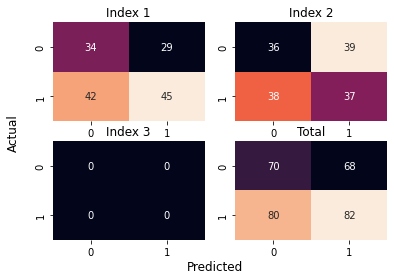

In [9]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [10]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks[['btcClose']], stocks_no_nan[['ethClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 8ms/step - loss: 0.0543 - accuracy: 0.5290 - val_loss: 0.0318 - val_accuracy: 0.5463
Epoch 2/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0112 - accuracy: 0.5280 - val_loss: 0.0052 - val_accuracy: 0.5463
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0061 - accuracy: 0.4679 - val_loss: 0.0019 - val_accuracy: 0.5463
Epoch 4/50
61/61 [==============================] - 0s 5ms/step - lo

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 1/2
Iteration 103 started
1/1 [==============================] - 0s 6ms/step - loss: 1.5362e-04 - accuracy: 1.0000
Accuracy: 0/2
Iteration 104 started
1/1 [==============================] - 0s 6ms/step - loss: 2.5702e-04 - accuracy: 0.0000e+00
Accuracy: 1/2
Iteration 105 started
1/1 [==============================] - 0s 10ms/step - loss: 4.1183e-04 - accuracy: 0.0000e+00
Accuracy: 0/2
Iteration 106 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0012 - accuracy: 0.0000e+00
Accuracy: 1/2
Iteration 107 started
1/1 [==============================] - 0s 6ms/step - loss: 6.9594e-04 - accuracy: 0.0000e+00
Accuracy: 1/2
Iteration 108 started
1/1 [==============================] - 0s 6ms/step - loss: 1.8043e-04 - accuracy: 0.0000e+00
Accuracy: 0/2
Iteration 109 started
1/1 [==============================] - 0s 7ms/step - loss: 4.7399e-04 - accuracy: 0.0000e+00
Accuracy: 0/2
Iteration 110 started
1/1 [==============================] - 0s 6ms/step - loss: 5.2117e-0

Day: 0 Accuracy: 0.5066666666666667
Day: 1 Accuracy: 0.5533333333333333
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


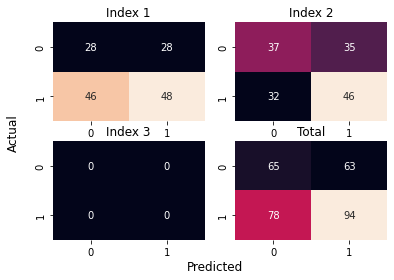

In [11]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [12]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks[['btcClose']], stocks[['adaClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 8ms/step - loss: 0.0543 - accuracy: 0.5290 - val_loss: 0.0318 - val_accuracy: 0.5463
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0112 - accuracy: 0.5280 - val_loss: 0.0052 - val_accuracy: 0.5463
Epoch 3/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0061 - accuracy: 0.4679 - val_loss: 0.0019 - val_accuracy: 0.5463
Epoch 4/50
61/61 [==============================] - 0s 5ms/step - lo

Day: 0 Accuracy: 0.44666666666666666
Day: 1 Accuracy: 0.5666666666666667
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


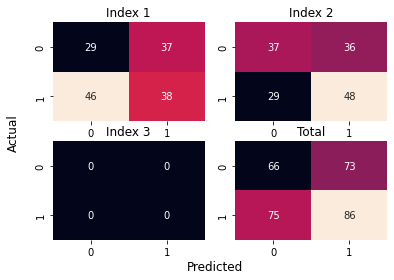

In [13]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [14]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_no_nan[['ethClose']], stocks[['btcClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 8ms/step - loss: 0.0358 - accuracy: 0.4959 - val_loss: 0.0022 - val_accuracy: 0.5463
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0116 - accuracy: 0.5104 - val_loss: 8.0329e-04 - val_accuracy: 0.5463
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.4979 - val_loss: 5.9380e-04 - val_accuracy: 0.4537
Epoch 4/50
61/61 [==============================] - 0s 5ms/s

Day: 0 Accuracy: 0.4533333333333333
Day: 1 Accuracy: 0.5133333333333333
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


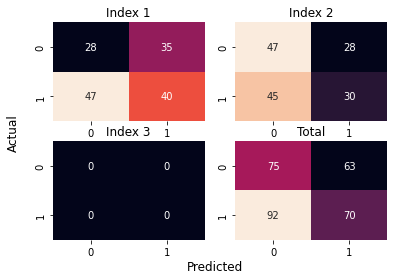

In [15]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [16]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_no_nan[['ethClose']], stocks_no_nan[['ethClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 8ms/step - loss: 0.0358 - accuracy: 0.4959 - val_loss: 0.0022 - val_accuracy: 0.5463
Epoch 2/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0116 - accuracy: 0.5104 - val_loss: 8.0329e-04 - val_accuracy: 0.5463
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.4979 - val_loss: 5.9380e-04 - val_accuracy: 0.4537
Epoch 4/50
61/61 [==============================] - 0s 5ms/s

Day: 0 Accuracy: 0.44
Day: 1 Accuracy: 0.48
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


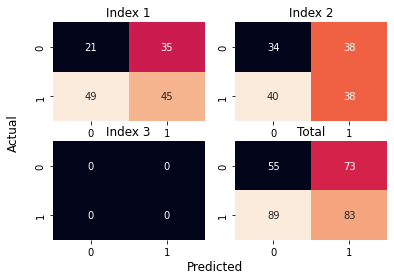

In [17]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [18]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_no_nan[['ethClose']], stocks_no_nan[['adaClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 9ms/step - loss: 0.0358 - accuracy: 0.4959 - val_loss: 0.0022 - val_accuracy: 0.5463
Epoch 2/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0116 - accuracy: 0.5104 - val_loss: 8.0329e-04 - val_accuracy: 0.5463
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0022 - accuracy: 0.4979 - val_loss: 5.9380e-04 - val_accuracy: 0.4537
Epoch 4/50
61/61 [==============================] - 0s 5ms/s

In [19]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_no_nan[['adaClose']], stocks[['btcClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 9ms/step - loss: 0.0161 - accuracy: 0.5000 - val_loss: 5.9049e-04 - val_accuracy: 0.4907
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0088 - accuracy: 0.4907 - val_loss: 1.5829e-04 - val_accuracy: 0.4907
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.5104 - val_loss: 8.4547e-05 - val_accuracy: 0.5000
Epoch 4/50
61/61 [==============================] - 0s 5

Day: 0 Accuracy: 0.46
Day: 1 Accuracy: 0.54
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


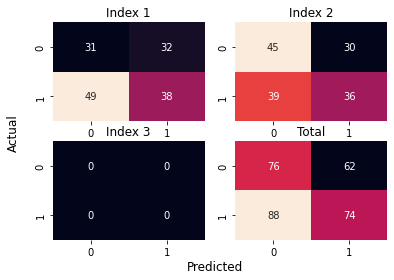

In [20]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [21]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_no_nan[['adaClose']], stocks_no_nan[['ethClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 9ms/step - loss: 0.0161 - accuracy: 0.5000 - val_loss: 5.9049e-04 - val_accuracy: 0.4907
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0088 - accuracy: 0.4907 - val_loss: 1.5829e-04 - val_accuracy: 0.4907
Epoch 3/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0029 - accuracy: 0.5104 - val_loss: 8.4547e-05 - val_accuracy: 0.5000
Epoch 4/50
61/61 [==============================] - 0s 4

Day: 0 Accuracy: 0.5066666666666667
Day: 1 Accuracy: 0.4666666666666667
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


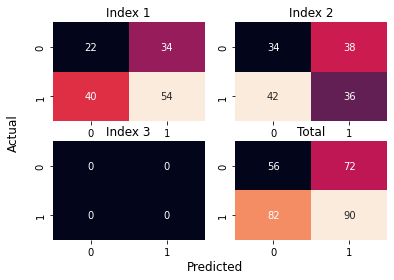

In [22]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)

In [23]:
seed(n_seed)
tf.random.set_seed(n_seed)
model = model_type(n_neurons=n_neurons, n_steps=n_steps, n_outputs=n_outputs, loss=loss, optimizer=optimizer)

cm = evaluate(model, stocks_no_nan[['adaClose']], stocks_no_nan[['adaClose']], n_evaluations=n_evaluations, n_test=n_outputs, n_steps=n_steps, n_epochs=epochs, batch_size=batch_size)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 15)                1020      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 32        
Total params: 1,052
Trainable params: 1,052
Non-trainable params: 0
_________________________________________________________________
None
Training on train_ts
Epoch 1/50
61/61 [==============================] - 2s 8ms/step - loss: 0.0161 - accuracy: 0.5000 - val_loss: 5.9049e-04 - val_accuracy: 0.4907
Epoch 2/50
61/61 [==============================] - 0s 4ms/step - loss: 0.0088 - accuracy: 0.4907 - val_loss: 1.5829e-04 - val_accuracy: 0.4907
Epoch 3/50
61/61 [==============================] - 0s 5ms/step - loss: 0.0029 - accuracy: 0.5104 - val_loss: 8.4547e-05 - val_accuracy: 0.5000
Epoch 4/50
61/61 [==============================] - 0s 5

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Accuracy: 2/2
Iteration 104 started
1/1 [==============================] - 0s 6ms/step - loss: 6.2742e-04 - accuracy: 1.0000
Accuracy: 1/2
Iteration 105 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0076 - accuracy: 1.0000
Accuracy: 2/2
Iteration 106 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0017 - accuracy: 1.0000
Accuracy: 0/2
Iteration 107 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0187 - accuracy: 0.0000e+00
Accuracy: 0/2
Iteration 108 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0402 - accuracy: 0.0000e+00
Accuracy: 0/2
Iteration 109 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0045 - accuracy: 0.0000e+00
Accuracy: 2/2
Iteration 110 started
1/1 [==============================] - 0s 6ms/step - loss: 0.0039 - accuracy: 1.0000
Accuracy: 1/2
Iteration 111 started
1/1 [==============================] - 0s 7ms/step - loss: 0.0033 - accuracy: 0.0000e+00
Accuracy: 1/

Day: 0 Accuracy: 0.48
Day: 1 Accuracy: 0.4666666666666667
Day: 2 Accuracy: nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


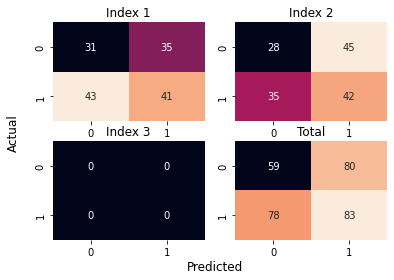

In [24]:
plot_confusion_matrix(cm)
print_effectiveness_by_day(cm)